<a href="https://colab.research.google.com/github/AkiraMJ/Modelagem-Computacional/blob/main/P%C3%B3rtico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Exemplo retirado do livro A First Course in Finite Element Method 4ª Edição - Daryl Logan Capítulo 5, Exemplo 5.1

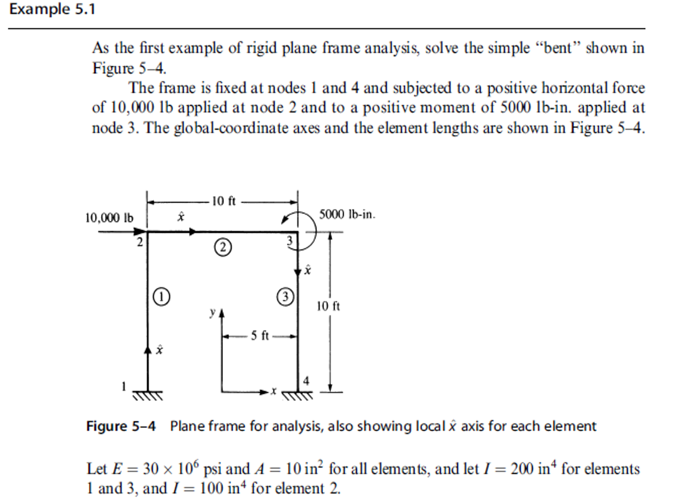

In [2]:
import requests
from PIL import Image
from io import BytesIO

file_id = '17xBPKJd-jV629SZNwn4C6kgqFEqY699-'
url = f'https://drive.google.com/uc?export=view&id={file_id}'

response = requests.get(url)
img = Image.open(BytesIO(response.content))

new_size = (700, 500)  # (largura, altura) em pixels
img_resized = img.resize(new_size)

display(img_resized)
#https://drive.google.com/file/d/17xBPKJd-jV629SZNwn4C6kgqFEqY699-/view?usp=drive_link


### 1. Preparação e Funções Auxiliares

A primeira etapa do código é a importação da biblioteca `numpy`, essencial para todas as operações matriciais (adição, multiplicação e inversão).

 Em seguida, são definidas duas funções cruciais. A função `matriz_transformacao_portico(C, S)` constrói a matriz de transformação ($T$, de $6 \times 6$) usando o cosseno ($C$) e o seno ($S$) diretores do elemento.

 Esta matriz é necessária para converter a rigidez de um elemento do seu sistema de coordenadas local para o sistema de coordenadas global. A função `matriz_rigidez_global_portico(k_local, T)` usa essa matriz de transformação para calcular a matriz de rigidez global do elemento, $\mathbf{K}_{\text{glo}} = \mathbf{T}^{\text{T}} \mathbf{k}_{\text{local}} \mathbf{T}$, que é o núcleo do Método da Rigidez.

---
### 2. Definição dos Dados de Entrada e Topologia

Esta seção configura o problema estrutural. O código define o **FATOR\_K** (250.000 lb/in³), que é o fator multiplicador comum das matrizes de rigidez no material didático. As coordenadas nodais (`coords`) e a conectividade (`conect`) definem a geometria e a topologia do pórtico.

Os **Graus de Liberdade (GLs)** são mapeados sequencialmente (1 a 12), onde os engastes nos nós 1 e 4 restringem os GLs 1, 2, 3 e 10, 11, 12. Os GLs livres (`GL_livres_base1`) são os restantes (4, 5, 6 no Nó 2 e 7, 8, 9 no Nó 3).

O vetor de forças global ($\mathbf{P}_{\text{global}}$) é criado e preenchido com as cargas aplicadas nos GLs correspondentes: $10.000 \text{ lb}$ em $P_{2x}$ (GL 4/Índice 3) e $5.000 \text{ lb-in}$ em $M_3$ (GL 9/Índice 8).

---
### 3. Montagem da Matriz de Rigidez Global ($\mathbf{K}$)

A matriz de rigidez global do pórtico ($\mathbf{K}_{\text{global}}$, de $12 \times 12$) é inicializada com zeros. O código itera sobre cada elemento (1, 2 e 3).

Para cada elemento, são calculados os fatores de rigidez ($AE/L$, $12EI/L^3$, $6EI/L^2$, etc.) e montada a matriz de rigidez local ($\mathbf{k}_{\text{local}}$) no formato $6 \times 6$.

Essa matriz local é então transformada para $\mathbf{K}_{\text{elem\_global}}$ usando a matriz $T$. Por fim, o processo de **superposição** (ou *assembly*) adiciona os termos de $\mathbf{K}_{\text{elem\_global}}$ nas posições corretas de $\mathbf{K}_{\text{global}}$, conforme o mapeamento dos GLs, realizando a integração das rigidezes de toda a estrutura.

---
### 4. Condensação e Resolução do Sistema

Após a montagem de $\mathbf{K}_{\text{global}}$, a etapa de condensação aplica as condições de contorno, eliminando as linhas e colunas dos GLs restritos. A matriz de rigidez condensada ($\mathbf{K}_{\text{cond}}$, de $6 \times 6$) é extraída, juntamente com o vetor de forças condensado ($\mathbf{R}_{\text{cond}}$, de $6 \times 1$). O problema é então reduzido ao sistema $\mathbf{R}_{\text{cond}} = \mathbf{K}_{\text{cond}} \mathbf{D}_{\text{cond}}$. A solução para os deslocamentos e rotações desconhecidos ($\mathbf{D}_{\text{cond}} = \mathbf{D}$) é encontrada usando o solucionador de sistemas lineares do `numpy` (`np.linalg.solve`), fornecendo os seis valores finais de deslocamentos.

---
### 5. Saída de Resultados

A última seção do código apresenta os vetores e matrizes finais. O código exibe o vetor $\mathbf{R}_{\text{cond}}$ (forças livres), a matriz $\mathbf{K}_{\text{cond}}$ (rigidez condensada) e o vetor $\mathbf{D}_{\text{cond}}$ (deslocamentos e rotações), que representam o resultado numérico da análise estática linear do pórtico.


In [26]:
import numpy as np
import math

# ==============================================================================
# 1. Definição das Funções Auxiliares (Matrizes)
# ==============================================================================

def matriz_transformacao_portico(C, S):
    """
    Gera a matriz de transformação 6x6 para pórtico plano (local para global).
    C = cos(theta), S = sin(theta)
    """
    T = np.zeros((6, 6))
    R = np.array([
        [C, S, 0],
        [-S, C, 0],
        [0, 0, 1]
    ])

    T[0:3, 0:3] = R
    T[3:6, 3:6] = R

    return T

def matriz_rigidez_global_portico(k_local, T):
    """
    Transforma a matriz de rigidez local para global: K_glo = T^T @ k_local @ T
    """
    return T.T @ k_local @ T

# ==============================================================================
# 2. Dados de Entrada do Exemplo 5.1
# ==============================================================================

# FATOR DE RIGIDEZ Comum (F): 250,000 lb/in³
FATOR_K = 250000
L = 10 * 12  # Comprimento de todas as barras: 120 in

# Propriedades de Rigidez (Termos I e A)
I_COL = 200.0  # I para Elemento 1 e 3
A_TERM_COL = 1.0
I_VIGA = 100.0 # I para Elemento 2
A_TERM_VIGA = 1.0

# Coordenadas Nodais Globais (em polegadas)
coords = {1: (-60, 0), 2: (-60, 120), 3: (60, 120), 4: (60, 0)}
conect = {1: (1, 2), 2: (2, 3), 3: (3, 4)}

# Numeração dos GLs: 1 a 12. GLs Livres (base 1): 4, 5, 6 (Nó 2) | 7, 8, 9 (Nó 3)
GL_livres_base1 = [4, 5, 6, 7, 8, 9]
idx_livres = [gl - 1 for gl in GL_livres_base1]

# Vetor de Forças Aplicadas Global (P, 12x1)
P_global = np.zeros(12)
P_global[3] = 10000  # P2x (GL 4, Índice 3) = 10,000 lb
P_global[8] = 5000   # M3 (GL 9, Índice 8) = 5,000 lb-in

# Dados dos Elementos
elementos_data = {
    1: {'L': L, 'I_term': I_COL, 'A_term': A_TERM_COL, 'n1': 1, 'n2': 2},
    2: {'L': L, 'I_term': I_VIGA, 'A_term': A_TERM_VIGA, 'n1': 2, 'n2': 3},
    3: {'L': L, 'I_term': I_COL, 'A_term': A_TERM_COL, 'n1': 3, 'n2': 4}
}

# ==============================================================================
# 3. Montagem da Matriz de Rigidez Global K (12x12)
# ==============================================================================

K_global = np.zeros((12, 12))

for i, data in elementos_data.items():
    L_elem = data['L']
    n1 = data['n1']
    n2 = data['n2']

    # Coordenadas e Diretores
    x1, y1 = coords[n1]; x2, y2 = coords[n2]
    C = (x2 - x1) / L_elem; S = (y2 - y1) / L_elem

    # Termos de Rigidez
    AE_L = FATOR_K * data['A_term']
    EI_L3 = FATOR_K * 12 * data['I_term'] / L_elem**2
    EI_L2_6 = FATOR_K * 6 * data['I_term'] / L_elem
    EI_L_4 = FATOR_K * 4 * data['I_term']
    EI_L_2 = FATOR_K * 2 * data['I_term']

    # Matriz de Rigidez Local (k_local)
    k_local = np.array([
        [ AE_L,       0,         0,      -AE_L,      0,         0    ],
        [ 0,        EI_L3,     EI_L2_6,   0,       -EI_L3,    EI_L2_6 ],
        [ 0,        EI_L2_6,   EI_L_4,    0,       -EI_L2_6,  EI_L_2  ],
        [ -AE_L,      0,         0,       AE_L,      0,         0    ],
        [ 0,       -EI_L3,    -EI_L2_6,  0,        EI_L3,    -EI_L2_6 ],
        [ 0,        EI_L2_6,   EI_L_2,    0,       -EI_L2_6,  EI_L_4  ]
    ])

    # Matriz de Rigidez Global do Elemento
    T = matriz_transformacao_portico(C, S)
    K_elem_global = matriz_rigidez_global_portico(k_local, T)

    # Mapeamento e Superposição
    gdl_map = np.array([3 * n1 - 3, 3 * n1 - 2, 3 * n1 - 1, 3 * n2 - 3, 3 * n2 - 2, 3 * n2 - 1])
    for r_idx in range(6):
        for c_idx in range(6):
            K_global[gdl_map[r_idx], gdl_map[c_idx]] += K_elem_global[r_idx, c_idx]

# ==============================================================================
# 4. Condensação e Resolução
# ==============================================================================

# Matriz K condensada (6x6)
K_cond = K_global[np.ix_(idx_livres, idx_livres)]

# Vetor de Forças condensado (R_cond, 6x1)
R_cond = P_global[idx_livres]

# Resolver para os deslocamentos D_cond (D)
D_cond = np.linalg.solve(K_cond, R_cond)

# ==============================================================================
# 5. Saída dos Resultados Finais
# ==============================================================================

# Mapeamento dos resultados com nomes (d2x, d2y, phi2, d3x, d3y, phi3)
GL_nomes = ['d2x', 'd2y', 'phi2', 'd3x', 'd3y', 'phi3']

print("=========================================================")
print("ANÁLISE DE PÓRTICO - MÉTODO DA RIGIDEZ (RESULTADO FINAL)")
print("=========================================================")

print("\n--- Vetor de Forças Condensado (R_cond) [lb, lb-in] ---")
print(R_cond)

print("\n--- Matriz de Rigidez Condensada (K_cond) [lb/in, lb/rad] ---")
# Limitando as casas decimais para visualização, como no material didático.
K_cond_formatted = np.around(K_cond, decimals=3)
print(K_cond_formatted)

print("\n--- Vetor de Deslocamentos Calculado (D_cond) [in, rad] ---")
print("{:<8} | {:<15}".format("GL", "Valor"))
print("-" * 25)
for nome, valor in zip(GL_nomes, D_cond):
    print("{:<8} | {:<15.6f}".format(nome, valor))

print("=========================================================")

ANÁLISE DE PÓRTICO - MÉTODO DA RIGIDEZ (RESULTADO FINAL)

--- Vetor de Forças Condensado (R_cond) [lb, lb-in] ---
[10000.     0.     0.     0.     0.  5000.]

--- Matriz de Rigidez Condensada (K_cond) [lb/in, lb/rad] ---
[[ 2.9167e+05  0.0000e+00  2.5000e+06 -2.5000e+05  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  2.7083e+05  1.2500e+06  0.0000e+00 -2.0833e+04  1.2500e+06]
 [ 2.5000e+06  1.2500e+06  3.0000e+08  0.0000e+00 -1.2500e+06  5.0000e+07]
 [-2.5000e+05  0.0000e+00  0.0000e+00  2.9167e+05  0.0000e+00  2.5000e+06]
 [ 0.0000e+00 -2.0833e+04 -1.2500e+06  0.0000e+00  2.7083e+05 -1.2500e+06]
 [ 0.0000e+00  1.2500e+06  5.0000e+07  2.5000e+06 -1.2500e+06  3.0000e+08]]

--- Vetor de Deslocamentos Calculado (D_cond) [in, rad] ---
GL       | Valor          
-------------------------
d2x      | 0.229686       
d2y      | 0.014280       
phi2     | -0.001773      
d3x      | 0.210234       
d3y      | -0.014280      
phi3     | -0.001559      
